# Assignment 3

In this analysis five different datasets are selected from http://www.timeseriesclassification.com/. Several models are trained for each dataset. Two different representations each with two different parameter sets are used to build the model. Then, distances between the time series are calculated using 4 different distance measures. In the classification step, 3 different k values are used in the K-NN algorithm. Accuracy of each model is calculated to determine the best performing model. Finally, the best performing model is tested on a seperate test set.

In [25]:
library(data.table)
library(ggplot2)
library(TSrepr)
library(caret)
library(TSdist)
library(dtw)
library(zoo)
library(rpart)
library(rattle)
require(TunePareto)

setwd("C:/Users/alpsr/Desktop/Assignment 3")

## Dataset 1: Plane

In this notebook, Plane dataset is evaluated. This dataset contains 105 training time series and 105 test time series. There are 7 different classes. First six time series in the training dataset are as follows.

In [26]:
dataset = 'PLANE'
train_data_path=sprintf('%s/%s/%s_TRAIN.txt',getwd(),dataset,dataset)

In [27]:
plane = fread(train_data_path)
plane <- setnames(plane, "V1", "Class")
plane <- data.table(plane)
plane[, "ID" := 1:.N]
plane[, "Class" := as.factor(Class)]
setcolorder(plane, c("ID", "Class"))
colnames(plane) <- c("ID", "Class",seq(1:144))
plane_matrix <- as.matrix(plane[,c(-1,-2)])
plane_long <- melt(plane,id.vars = c("ID","Class"))
plane_long[,variable := as.numeric(variable)]
plane_class <- plane$Class
head(plane)

ID,Class,1,2,3,4,5,6,7,8,...,135,136,137,138,139,140,141,142,143,144
<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2.483940,2.2762865,2.0675157,1.9218926,1.7187752,1.50842850,1.3006752,1.0902862,...,0.7133945,0.9158603,1.1204496,1.3263464,1.5322099,1.7399188,1.9457323,2.1539857,2.3612278,2.4839393
2,4,2.603320,2.3406991,2.0822848,1.8256242,1.5677057,1.31220300,1.0571948,0.8017157,...,0.4272742,0.6760656,0.9212985,1.1717223,1.4188965,1.6636066,1.9158275,2.1624669,2.4052760,2.6052935
3,6,2.757321,2.5766667,2.3633233,2.1515785,1.9402183,1.72942750,1.5194285,1.3095473,...,0.9542680,1.1573429,1.3633172,1.5663255,1.7698597,1.9738637,2.1782898,2.3808412,2.5849446,2.7591348
4,5,0.916063,0.7201453,0.5224446,0.3258262,0.1343814,-0.05401188,-0.2355249,-0.4096045,...,1.1333979,0.9843523,0.7606417,0.5415025,0.5173423,0.5828356,0.6586408,0.7579009,0.8534012,0.9162167
5,2,2.656142,2.3881447,2.1185954,1.8496769,1.5765789,1.31016860,1.1096989,0.9309980,...,0.6366630,0.7924025,0.9860716,1.1789434,1.3926792,1.6603249,1.9292371,2.1991619,2.4699927,2.6555235
6,6,2.716798,2.5208585,2.3196204,2.1164411,1.9136371,1.71124980,1.5093279,1.3046473,...,0.9362289,1.1431900,1.3506284,1.5586054,1.7671641,1.9762411,2.1858814,2.3967625,2.6088970,2.7148302


## Classes

Seven classes from the dataset are as follows.

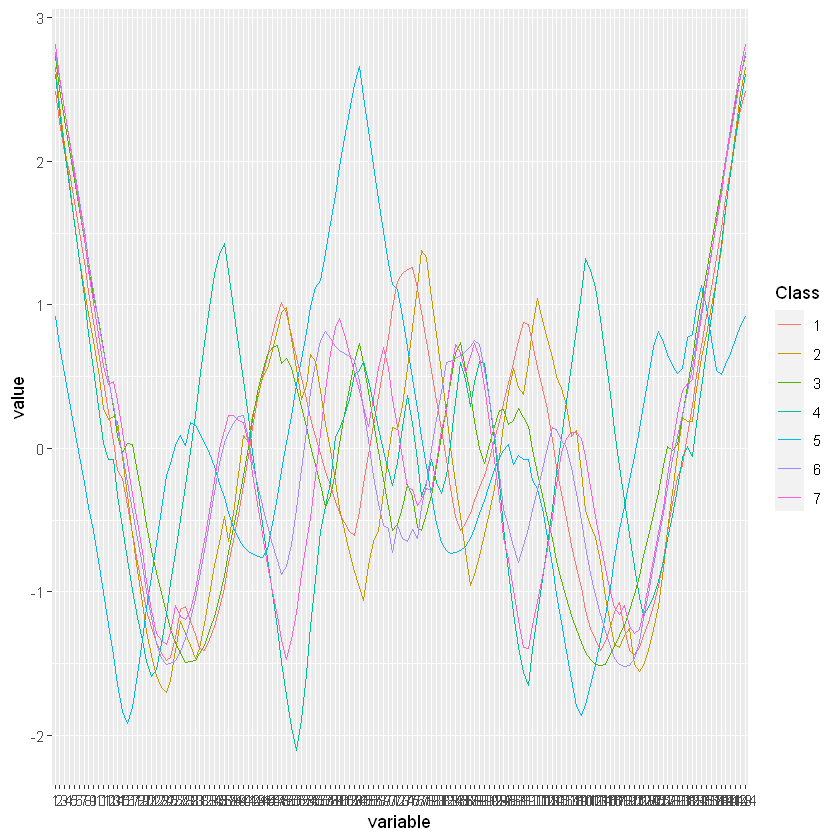

In [28]:
plane_class_1 <- melt(plane[,head(.SD, 1), Class],id.vars = c("ID","Class"))

ggplot(plane_class_1, aes(x = variable, y = value, group = Class)) +
geom_line(aes(color = Class))

## Representations

Two different representations are used in this analysis. First one is SAX (symbolic aggregate approximation) and second is the APCA (Adaptive Piecewise Constant Approximation) using regression trees.

### Symbolic Aggregate Approximation

In [29]:
plane_sax_q12 <- repr_matrix(plane_matrix,repr_sax,args = list(q = 12, a = 5))
plane_sax_q6 <- repr_matrix(plane_matrix,repr_sax,args = list(q = 6, a = 5))

index1 = seq(1,143, by = 12)
for(i in seq(1,105)){
    plane_long[(variable %in% index1) & (ID == i), SAX_q12 := plane_sax_q12[i,]]
    plane_long[ID == i, SAX_q12_fit := plane_long[ID == i, na.locf(SAX_q12)]]
}

index2 = seq(1,143, by = 6)
for(i in seq(1,105)){
    plane_long[(variable %in% index2) & (ID == i), SAX_q6 := plane_sax_q6[i,]]
    plane_long[ID == i, SAX_q6_fit := plane_long[ID == i, na.locf(SAX_q6)]]
}

plane_long[, SAX_q12_fit_value := mean(value), by = .(SAX_q12_fit,ID)]
plane_long[, SAX_q6_fit_value := mean(value), by = .(SAX_q6_fit,ID)]

### Regression Trees

In [30]:
for(i in seq(1,105)){
    selected_series <- plane_long[ID == i]
    tree_fit=rpart(value~variable,selected_series,control=rpart.control(maxdepth=3, cp = 0, minsplit = 20, minbucket = 10))
    #fancyRpartPlot(tree_fit)
    plane_long[ID == i, Tree_fit_d3 := predict(tree_fit, selected_series)]
}

for(j in seq(1,105)){
    selected_series <- plane_long[ID == j]
    tree_fit=rpart(value~variable,selected_series,control=rpart.control(maxdepth=4, cp = 0, minsplit = 20, minbucket = 10))
    #fancyRpartPlot(tree_fit)
    plane_long[ID == j, Tree_fit_d4 := predict(tree_fit, selected_series)]
}

head(plane_long)

ID,Class,variable,value,SAX_q12,SAX_q12_fit,SAX_q6,SAX_q6_fit,SAX_q12_fit_value,SAX_q6_fit_value,Tree_fit_d3,Tree_fit_d4
<int>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,2.483940,e,e,e,e,1.40571269,1.7068239,1.59228333,1.59228333
2,4,1,2.603320,e,e,e,e,1.24472255,1.5243258,1.44292793,1.44292793
3,6,1,2.757321,e,e,e,e,1.64603627,1.6460363,1.83392569,1.83392569
4,5,1,0.916063,c,c,d,d,-0.09008921,0.5146495,0.05629129,0.05629129
5,2,1,2.656142,e,e,e,e,1.34219503,1.6520688,1.52300054,1.52300054
6,6,1,2.716798,e,e,e,e,1.63372137,1.6337214,1.81157810,1.81157810


## Distance Measures

Three different distances measures are used. First one is the Euclidean Distance. Remaining ones are Dynamic Time Warping (DTW), Longest Common Subsequence (LCSS) and Edit Distance with Real Penalties (ERP).

### Euclidean Distance

In [31]:
#plane_matrix <- as.matrix(plane[,c(-1,-2)]) #ncol = 144, nrow = 105, byrow = TRUE )
plane_euclidean_raw <- as.matrix(dist(plane_matrix))

plane_SAX_q12_matrix <- dcast(plane_long, ID + Class ~ variable, value.var = "SAX_q12_fit_value")
plane_SAX_q6_matrix <- dcast(plane_long, ID + Class ~ variable, value.var = "SAX_q6_fit_value")
plane_RegTree_d3_matrix <- dcast(plane_long, ID + Class ~ variable, value.var = "Tree_fit_d3")
plane_RegTree_d4_matrix <- dcast(plane_long, ID + Class ~ variable, value.var = "Tree_fit_d4")

plane_euclidean_sax_q12 <- as.matrix(dist(as.matrix(plane_SAX_q12_matrix[,c(-1,-2)])))
plane_euclidean_sax_q6 <- as.matrix(dist(as.matrix(plane_SAX_q6_matrix[,c(-1,-2)])))
plane_euclidean_RegTree_d3 <- as.matrix(dist(as.matrix(plane_RegTree_d3_matrix[,c(-1,-2)])))
plane_euclidean_RegTree_d4 <- as.matrix(dist(as.matrix(plane_RegTree_d4_matrix[,c(-1,-2)])))

### Dynamic Time Warping

In [32]:
plane_dtw_sax_q12 <- as.matrix(TSDatabaseDistances(X = plane_SAX_q12_matrix[,c(-1,-2)], distance = 'dtw'))
plane_dtw_sax_q6 <- as.matrix(TSDatabaseDistances(X = plane_SAX_q6_matrix[,c(-1,-2)], distance = 'dtw'))
plane_dtw_RegTree_d3 <- as.matrix(TSDatabaseDistances(X = plane_RegTree_d3_matrix[,c(-1,-2)], distance = 'dtw'))
plane_dtw_RegTree_d4 <- as.matrix(TSDatabaseDistances(X = plane_RegTree_d4_matrix[,c(-1,-2)], distance = 'dtw'))
plane_dtw_raw <- as.matrix(TSDatabaseDistances(X = plane_matrix, distance = 'dtw'))

### LCSS

In [33]:
plane_lcss_raw <- as.matrix(TSDatabaseDistances(X = plane_matrix, distance = 'lcss', epsilon = 0.1))
plane_lcss_sax_q12 <- as.matrix(TSDatabaseDistances(X = plane_SAX_q12_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
plane_lcss_sax_q6 <- as.matrix(TSDatabaseDistances(X = plane_SAX_q6_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
plane_lcss_RegTree_d3 <- as.matrix(TSDatabaseDistances(X = plane_RegTree_d3_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
plane_lcss_RegTree_d4 <- as.matrix(TSDatabaseDistances(X = plane_RegTree_d4_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))

### ERP

In [34]:
plane_erp_raw <- as.matrix(TSDatabaseDistances(X = plane_matrix, distance = 'erp', g = 0))
plane_erp_sax_q12 <- as.matrix(TSDatabaseDistances(X = plane_SAX_q12_matrix[,c(-1,-2)], distance = 'erp', g = 0))
plane_erp_sax_q6 <- as.matrix(TSDatabaseDistances(X = plane_SAX_q6_matrix[,c(-1,-2)], distance = 'erp', g = 0))
plane_erp_RegTree_d3 <- as.matrix(TSDatabaseDistances(X = plane_RegTree_d3_matrix[,c(-1,-2)], distance = 'erp', g = 0))
plane_erp_RegTree_d4 <- as.matrix(TSDatabaseDistances(X = plane_RegTree_d4_matrix[,c(-1,-2)], distance = 'erp', g = 0))

## Generating Runs

After building the distance matrices, each model's performance is measured using the 10-fold stratified cross validation with 5 repeats.

### Cross-Validation Runs

In [35]:
set.seed(12435)
cv_indices = generateCVRuns(plane_class, ntimes = 5, nfold = 10, 
                            leaveOneOut = FALSE, stratified = TRUE)
str(cv_indices)

List of 5
 $ Run  1:List of 10
  ..$ Fold  1 : int [1:11] 39 84 19 60 13 67 25 62 24 92 ...
  ..$ Fold  2 : int [1:11] 95 27 40 11 100 63 93 5 51 57 ...
  ..$ Fold  3 : int [1:11] 42 48 68 29 75 54 9 41 98 102 ...
  ..$ Fold  4 : int [1:11] 1 101 88 73 65 46 89 79 32 36 ...
  ..$ Fold  5 : int [1:11] 83 17 44 3 21 86 78 104 66 69 ...
  ..$ Fold  6 : int [1:10] 38 105 26 10 22 45 28 37 53 12
  ..$ Fold  7 : int [1:10] 56 47 2 99 7 91 61 50 74 64
  ..$ Fold  8 : int [1:10] 72 103 15 16 35 4 87 49 14 59
  ..$ Fold  9 : int [1:10] 33 90 58 81 94 85 97 23 20 55
  ..$ Fold  10: int [1:10] 8 18 80 6 77 43 34 82 30 70
 $ Run  2:List of 10
  ..$ Fold  1 : int [1:11] 95 39 15 58 35 46 43 87 24 51 ...
  ..$ Fold  2 : int [1:11] 33 17 88 6 13 4 67 61 98 14 ...
  ..$ Fold  3 : int [1:11] 1 101 103 22 100 54 5 97 102 32 ...
  ..$ Fold  4 : int [1:11] 84 42 18 75 81 85 78 41 12 36 ...
  ..$ Fold  5 : int [1:11] 8 83 105 94 7 77 9 28 49 50 ...
  ..$ Fold  6 : int [1:10] 27 60 80 73 99 93 79 62 92 66
 

### k-NN Classifier

In [36]:
nn_classify_cv=function(dist_matrix,train_class,test_indices,k=1){
    
    test_distances_to_train=dist_matrix[test_indices,]
    test_distances_to_train=test_distances_to_train[,-test_indices]
    train_class=train_class[-test_indices]
    ordered_indices=apply(test_distances_to_train,1,order)
    
    if(k==1){
        nearest_class=as.numeric(train_class[as.numeric(ordered_indices[1,])])
        nearest_class=data.table(id=test_indices,nearest_class)
    } else {
        nearest_class=apply(ordered_indices[1:k,],2,function(x) {train_class[x]})
        nearest_class=data.table(id=test_indices,t(nearest_class))
    }
    
    long_nn_class=melt(nearest_class,'id')

    class_counts=long_nn_class[,.N,list(id,value)]
    class_counts[,predicted_prob:=N/k]
    wide_class_prob_predictions=dcast(class_counts,id~value,value.var='predicted_prob')
    wide_class_prob_predictions[is.na(wide_class_prob_predictions)]=0
    class_predictions=class_counts[,list(predicted=value[which.max(N)]),by=list(id)]
    
    
    return(list(prediction=class_predictions,prob_estimates=wide_class_prob_predictions))
    
}

### Testing the Models

In [37]:
#approach_file=list.files(dist_folder)
dist = list(plane_euclidean_raw,
            plane_euclidean_sax_q12,
            plane_euclidean_sax_q6,
            plane_euclidean_RegTree_d3,
            plane_euclidean_RegTree_d4,
            plane_dtw_raw,
            plane_dtw_sax_q12,
            plane_dtw_sax_q6,
            plane_dtw_RegTree_d3,
            plane_dtw_RegTree_d4,
            plane_lcss_raw,
            plane_lcss_sax_q6,
            plane_lcss_sax_q12,
            plane_lcss_RegTree_d3,
            plane_lcss_RegTree_d4,
            plane_erp_raw,
            plane_erp_sax_q6,
            plane_erp_sax_q12,
            plane_erp_RegTree_d3,
            plane_erp_RegTree_d4)

n_dist = 15
nof_rep = 5
n_fold = 10
k_levels=c(1,5,10)
result = vector('list',n_dist*nof_rep*n_fold*length(k_levels))
iter = 1
names = c("plane_euclidean_raw","plane_euclidean_sax_q12","plane_euclidean_sax_q6",
         "plane_euclidean_RegTree_d3","plane_euclidean_RegTree_d4",
         "plane_dtw_raw","plane_dtw_sax_q12","plane_dtw_sax_q6","plane_dtw_RegTree_d3",
         "plane_dtw_RegTree_d4","plane_lcss_raw","plane_lcss_sax_q6","plane_lcss_sax_q12",
         "plane_lcss_RegTree_d3","plane_lcss_RegTree_d4","plane_erp_raw","plane_erp_sax_q6",
         "plane_erp_sax_q12","plane_erp_RegTree_d3","plane_erp_RegTree_d4")

In [38]:
CrossValidationTrain <- function(dist,cv_index, train_class){
    n_dist = 20
    nof_rep = 5
    n_fold = 10
    k_levels=c(1,3,5)

    for(m in 1:n_dist){ #
        current_dist = dist[[m]]
        for(i in 1:nof_rep){
            this_fold=cv_index[[i]]
            for(j in 1:n_fold){
                test_indices=this_fold[[j]]
                for(k in 1:length(k_levels)){
                    current_k=k_levels[k]
                    current_fold=nn_classify_cv(current_dist,train_class,test_indices,k=current_k)
                    accuracy=sum(train_class[test_indices]==current_fold$prediction$predicted)/length(test_indices)
                    tmp=data.table(approach=names[[m]],repid=i,foldid=j,
                                   k=current_k,acc=accuracy)
                    
                    result[[iter]]=tmp
                    iter=iter+1
                }
            }
        }   
    }
    return(result)
}

Mean and standart deviation of each model is reported below. There are several best performing models. DTW on the raw series has 100% accuracy (regardless of the k parameter) and ERP on the raw series also has 100% accuracy for k=5. For the final testing the DTW with k=1 wil be used.

In [19]:
result_plane = CrossValidationTrain(dist,cv_indices, plane_class)

result_plane = rbindlist(result_plane)

results_summary <- result_plane[,.(Mean = mean(acc),SD = sd(acc)),.(approach,k)]
results_summary[order(-Mean)]

approach,k,Mean,SD
<chr>,<dbl>,<dbl>,<dbl>
plane_dtw_raw,1,1.000000000,0.00000000
plane_dtw_raw,3,1.000000000,0.00000000
plane_dtw_raw,5,1.000000000,0.00000000
plane_erp_raw,5,1.000000000,0.00000000
plane_erp_raw,3,0.992545455,0.02556100
plane_erp_raw,1,0.990727273,0.02812461
plane_euclidean_raw,3,0.990545455,0.02868690
plane_dtw_sax_q6,3,0.985090909,0.03454448
plane_erp_sax_q6,1,0.980909091,0.03862408


## Testing

In [21]:
test_data_path=sprintf('%s/%s/%s_TEST.txt',getwd(),dataset,dataset)

plane_train = fread(train_data_path)
plane_test = fread(test_data_path)

plane_test <- setnames(plane_test, "V1", "Class")
plane_train <- setnames(plane_train, "V1", "Class")

plane_test <- data.table(plane_test)
plane_train <- data.table(plane_train)

plane_test[, "ID" := (1:.N)+105]
plane_test[, "Class" := as.factor(Class)]
plane_train[, "ID" := (1:.N)]
plane_train[, "Class" := as.factor(Class)]

plane_comb <- rbindlist(list(plane_train,plane_test),use.names = TRUE)

setcolorder(plane_comb, c("ID", "Class"))
colnames(plane_comb) <- c("ID", "Class",seq(1:144))
plane_comb_matrix <- as.matrix(plane_comb[,c(-1,-2)])
plane_comb_long <- melt(plane_comb,id.vars = c("ID","Class"))
plane_comb_long[,variable := as.numeric(variable)]
plane_comb_class <- plane_comb$Class

test_index_final = seq(106,210)

plane_comb_dtw_raw <- as.matrix(TSDatabaseDistances(X = plane_comb_matrix, distance = 'dtw'))

overall_result <- nn_classify_cv(plane_comb_dtw_raw,plane_comb_class,test_index_final,k=1)

In [23]:
Test_Accuracy <- sum(plane_comb_class[test_index_final]==overall_result$prediction$predicted)/length(test_index_final)
Test_Accuracy

[1] 1

Finally, the best performing model is used to classify the test data and its test accuracy is 100%

Summary of the best performing model is as follows:

In [24]:
Dataset <- "Plane"
Cross_Validation_Mean_Accuracy <- max(results_summary$Mean)
Distance = 'DTW'
Representation = 'Raw'
K = '1'
df <- data.frame(Dataset,Cross_Validation_Mean_Accuracy,Test_Accuracy,Distance,Representation,K)
df

Dataset,Cross_Validation_Mean_Accuracy,Test_Accuracy,Distance,Representation,K
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
Plane,1,1,DTW,Raw,1
